In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import os
import gc

In [2]:
gc.collect()

0

In [3]:
def read_vcf(vcf_file):

    header = []
    col_line = None
    with open(vcf_file, 'r') as f:
        for line in f:
            if '#CHROM' in line:
                col_line = col_line
                break
            else:
                header.append(line)

    cols = line.strip('\n')
    cols = cols.strip('#').rsplit('\t')
    col_types = {col:str for col in cols}

    df = pd.read_csv(vcf_file, sep='\t', names = cols, header = None, comment = '#', dtype=col_types)

    return header, df

In [4]:
path = '/Users/jerenolsen/Desktop/Genomics_Pipeline_Versions/Genomics_Pipeline/2. Imputation/final_output/hu1AF4ED_23andMe_imputed.vcf'
_,df = read_vcf(path)

In [71]:
df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,hu1AF4ED
4,10,60969,rs61838556,C,A,.,PASS,DR2=0.03;AF=0.9673;IMP,GT:DS,1|1:1.93
32,10,64767,rs61838558,C,T,.,PASS,DR2=0.02;AF=0.9778;IMP,GT:DS,1|1:1.96
36,10,65878,rs28887774,C,G,.,PASS,DR2=0.02;AF=0.9773;IMP,GT:DS,1|1:1.95
40,10,66695,rs368405462,T,A,.,PASS,DR2=0.02;AF=0.9778;IMP,GT:DS,1|1:1.96
50,10,67774,rs9943471,G,C,.,PASS,DR2=0.00;AF=1.0000;IMP,GT:DS,1|1:2


# Filter out non-SNPs

In [6]:
df = df[df['REF'].str.len() == 1]
df = df[df['ALT'].str.len() == 1]
len(df)

27904794

# Filter out MAF < 0.05

In [7]:
print(len(df))
af_col = df['INFO'].str[12:18]
af_filter = af_col.astype(float) > 0.05
df = df[af_filter]
print(len(df))


27904794
3926780


# Filter Poorly Imputed SNPs (low dosage squared)

In [8]:
dr2_col = df['INFO'].str[4:8]

In [9]:
dr2_col

4           0.03
32          0.02
36          0.02
40          0.02
50          0.00
            ... 
30761482    0.12
30761483    0.12
30761485    0.08
30761486    0.56
30761487    0.05
Name: INFO, Length: 3926780, dtype: object

In [10]:
non_imputed = df[df['INFO'].str.contains('IMP') == False]

In [11]:
non_imputed.head(20)

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,hu1AF4ED
724,10,135708,rs7917054,G,A,.,PASS,DR2=1.00;AF=0.5000,GT:DS,1|0:1
726,10,135853,rs7906287,A,G,.,PASS,DR2=0.00;AF=1.0000,GT:DS,1|1:2
938,10,158946,rs11253562,C,T,.,PASS,DR2=1.00;AF=0.5000,GT:DS,1|0:1
1675,10,237750,rs11250790,G,A,.,PASS,DR2=0.00;AF=1.0000,GT:DS,1|1:2
2189,10,291134,rs10508201,T,C,.,PASS,DR2=0.00;AF=1.0000,GT:DS,1|1:2
2203,10,291999,rs3123252,G,A,.,PASS,DR2=0.00;AF=1.0000,GT:DS,1|1:2
2563,10,325841,rs17221260,G,T,.,PASS,DR2=0.00;AF=1.0000,GT:DS,1|1:2
2726,10,338553,rs3125031,C,T,.,PASS,DR2=0.00;AF=1.0000,GT:DS,1|1:2
2907,10,353306,rs4881041,G,A,.,PASS,DR2=0.00;AF=1.0000,GT:DS,1|1:2
3746,10,412449,rs1133113,A,G,.,PASS,DR2=0.00;AF=1.0000,GT:DS,1|1:2


In [12]:
dr2_filter = non_imputed[non_imputed['INFO'].str[4:8].astype(float) == 0]

In [13]:
print(len(non_imputed))
len(dr2_filter)

261204


101096

In [14]:
x = dr2_col.astype(float)
x_sub = x[0:100000]

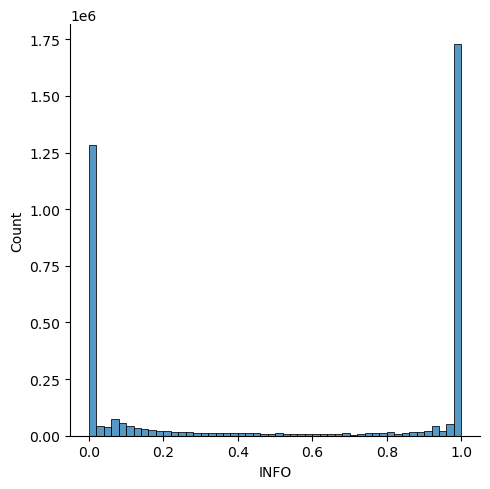

In [15]:
import seaborn as sns, numpy as np

ax = sns.displot(x, bins = 50)

# TODO:
##### - Load 23andMe imputed file and its equivalent but original CGI file (preprocessed). 
##### - Take imputed 23andMe file and filter out positions not seen in CGI File
##### - Filter out non-imputed positions
## Assess how accurate the imputed positions are vs the canon CGI positions. Is there a pattern in DR2 scores for correctly vs incorrectly imputed genotypes? - If yes use this as a heuristic for filtering using DR2 in all imputed data.

### In summary: filtering on DR2 score ->will not improve<- the proportion of incorrectly called variants to correctly called

In [16]:
canon_CG_path = '/Users/jerenolsen/Desktop/Genomics_Pipeline_Versions/Genomics_Pipeline/1. Preprocessing/output/hu1AF4ED_CGI_preprocessed_b37.vcf'
imp_23andMe_path = '/Users/jerenolsen/Desktop/Genomics_Pipeline_Versions/Genomics_Pipeline/2. Imputation/final_output/hu1AF4ED_23andMe_imputed.vcf'

In [23]:
_,canon_CGI = read_vcf(canon_CG_path)

In [24]:
_,imp_23andMe = read_vcf(imp_23andMe_path)

In [25]:
canon_CGI.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,hu1AF4ED
0,1,38232,.,A,G,.,.,.,GT,1/1
1,1,38907,.,C,T,.,.,.,GT,0/1
2,1,41981,rs806721,A,G,.,.,.,GT,1/1
3,1,47108,rs2531241,G,C,.,.,.,GT,0/1
4,1,47292,rs2691275,T,G,.,.,.,GT,0/1


# Process Canon CG

In [26]:
df_c = pd.DataFrame()
df_c = pd.concat([df_c, canon_CGI])
df_c = df_c[df_c['CHROM'].str.contains('X')==False]
print(len(df_c))

3241617


In [27]:
df_c['ID'].value_counts()

.             90251
ncv_id           11
mut               4
rs1758914         2
rs2630903         2
              ...  
rs4700160         1
rs12519061        1
rs13164407        1
rs4429803         1
rs2238838         1
Name: ID, Length: 3151295, dtype: int64

In [28]:
#Only with known rsids
df_c = df_c[df_c['ID'].isin([".","ncv_id","mut"]) == False]

In [29]:
len(df_c)

3151351

# Process Imputed 23andMe

In [30]:
df_i = pd.DataFrame()
df_i = pd.concat([df_i,imp_23andMe])

In [31]:
#SNPs only
df_i = df_i[df_i['REF'].str.len() == 1]
df_i = df_i[df_i['ALT'].str.len() == 1]

In [32]:
#Imputed only
df_i = df_i[df_i['INFO'].str.contains('IMP')==True]

In [33]:
#allele freq > 0.05
af_col = df_i['INFO'].str[12:18]
af_filter = af_col.astype(float) > 0.05
df_i = df_i[af_filter]
len(df_i)

3665576

In [34]:
#Remove entries missing external IDs
df_i = df_i[df_i['ID']!='.']

- df_c only contains complete genomics variants that were present in the original file, of passing quality
- df_i contains all imputed variants based on a 23andMe file for the same individual, not including the original variants
- Taking the intersection of these two datasets will result in positions that were imputed from the 23andMe file that are also present in the original CGI file, allowing for comparison of imputed variants to real variant calls

In [36]:
#df_i

In [37]:
df_i['unique_id'] = df_i['ID'].str.slice(start=2)
df_c['unique_id'] = df_c['ID'].str.slice(start=2)

In [39]:
df_i['unique_id'] = df_i['unique_id'].astype(int)
df_c['unique_id'] = df_c['unique_id'].astype(int)

In [40]:
df_i = df_i.sort_values('unique_id')
df_c = df_c.sort_values('unique_id')

In [41]:
df_m = pd.merge(df_i, df_c, on="unique_id")

In [42]:
cols = df_m.columns
rem = ['QUAL_x','QUAL_y','FILTER_y','INFO_y','FORMAT_x','FORMAT_y','CHROM_y','POS_y','ID_y']
cols = [col for col in cols if col not in rem]
cols

['CHROM_x',
 'POS_x',
 'ID_x',
 'REF_x',
 'ALT_x',
 'FILTER_x',
 'INFO_x',
 'hu1AF4ED_x',
 'unique_id',
 'REF_y',
 'ALT_y',
 'hu1AF4ED_y']

In [43]:
df_m = df_m[cols]

In [44]:
df_m

,CHROM_x,POS_x,ID_x,REF_x,ALT_x,FILTER_x,INFO_x,hu1AF4ED_x,unique_id,REF_y,ALT_y,hu1AF4ED_y
0,7,92383888,rs10,A,C,PASS,DR2=0.00;AF=0.9997;IMP,1|1:2,10,A,C,1/1
1,7,11597105,rs20,G,A,PASS,DR2=0.00;AF=1.0000;IMP,1|1:2,20,G,A,1/1
2,7,11596296,rs23,T,C,PASS,DR2=0.00;AF=1.0000;IMP,1|1:2,23,T,C,1/1
3,7,11598219,rs24,G,C,PASS,DR2=0.00;AF=1.0000;IMP,1|1:2,24,G,C,1/1
4,7,11583225,rs27,G,C,PASS,DR2=0.00;AF=1.0000;IMP,1|1:2,27,G,C,1/1
...,...,...,...,...,...,...,...,...,...,...,...,...
2721429,13,19847553,rs202234027,T,C,PASS,DR2=0.00;AF=1.0000;IMP,1|1:2,202234027,T,C,1/1
2721430,11,117683565,rs202234193,A,C,PASS,DR2=0.51;AF=0.6631;IMP,1|0:1.33,202234193,A,C,0/1
2721431,8,80656962,rs202239594,A,G,PASS,DR2=0.92;AF=0.4792;IMP,1|0:0.96,202239594,A,G,0/1
2721432,20,15313597,rs202239817,T,C,PASS,DR2=1.00;AF=0.5000;IMP,1|0:1,202239817,T,C,0/1


In [45]:
to_int = lambda x: [int(item) for item in x]
sum_func = lambda x: sum(x)

In [48]:
df_m['sum_x'] = df_m['hu1AF4ED_x'].str.slice(start=0, stop = 3)
df_m['sum_x'] = df_m['sum_x'].str.split('|').tolist()
df_m['sum_x'] = df_m['sum_x'].apply(to_int)
df_m['sum_x'] = df_m['sum_x'].apply(sum_func)

In [49]:
df_m['sum_y'] = df_m['hu1AF4ED_y'].str.split('/').tolist()
df_m['sum_y'] = df_m['sum_y'].apply(to_int)
df_m['sum_y'] = df_m['sum_y'].apply(sum_func)

In [50]:
df_m

,CHROM_x,POS_x,ID_x,REF_x,ALT_x,FILTER_x,INFO_x,hu1AF4ED_x,unique_id,REF_y,ALT_y,hu1AF4ED_y,sum_x,sum_y
0,7,92383888,rs10,A,C,PASS,DR2=0.00;AF=0.9997;IMP,1|1:2,10,A,C,1/1,2,2
1,7,11597105,rs20,G,A,PASS,DR2=0.00;AF=1.0000;IMP,1|1:2,20,G,A,1/1,2,2
2,7,11596296,rs23,T,C,PASS,DR2=0.00;AF=1.0000;IMP,1|1:2,23,T,C,1/1,2,2
3,7,11598219,rs24,G,C,PASS,DR2=0.00;AF=1.0000;IMP,1|1:2,24,G,C,1/1,2,2
4,7,11583225,rs27,G,C,PASS,DR2=0.00;AF=1.0000;IMP,1|1:2,27,G,C,1/1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2721429,13,19847553,rs202234027,T,C,PASS,DR2=0.00;AF=1.0000;IMP,1|1:2,202234027,T,C,1/1,2,2
2721430,11,117683565,rs202234193,A,C,PASS,DR2=0.51;AF=0.6631;IMP,1|0:1.33,202234193,A,C,0/1,1,1
2721431,8,80656962,rs202239594,A,G,PASS,DR2=0.92;AF=0.4792;IMP,1|0:0.96,202239594,A,G,0/1,1,1
2721432,20,15313597,rs202239817,T,C,PASS,DR2=1.00;AF=0.5000;IMP,1|0:1,202239817,T,C,0/1,1,1


In [52]:
df_equiv = df_m[df_m['sum_x'] == df_m['sum_y']]
df_unequiv = df_m[df_m['sum_x'] != df_m['sum_y']]

In [53]:
import seaborn as sns, numpy as np
import matplotlib.pyplot as plt
#ax = sns.displot(x, bins = 50)
#displot
#histplot

In [54]:
equiv_scores = df_equiv['INFO_x'].str.slice(start = 4, stop =7)
equiv_scores = sorted(equiv_scores)

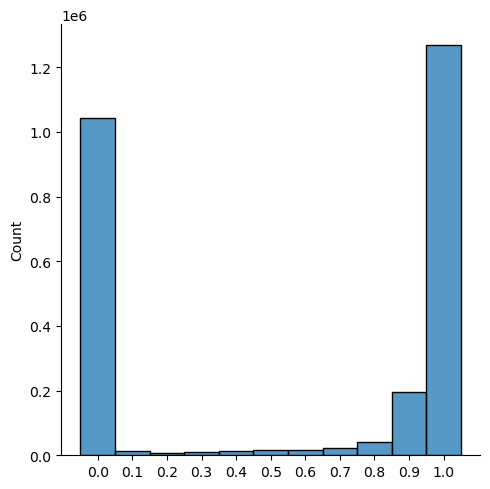

In [55]:
x = sns.displot(equiv_scores, bins=50)
plt.show()

In [56]:
unequiv_scores = df_unequiv['INFO_x'].str.slice(start = 4, stop =7)
unequiv_scores = sorted(unequiv_scores)

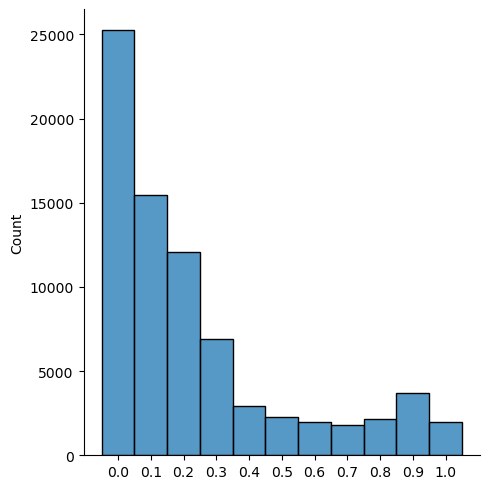

In [57]:
x = sns.displot(unequiv_scores, bins=50)
plt.show()

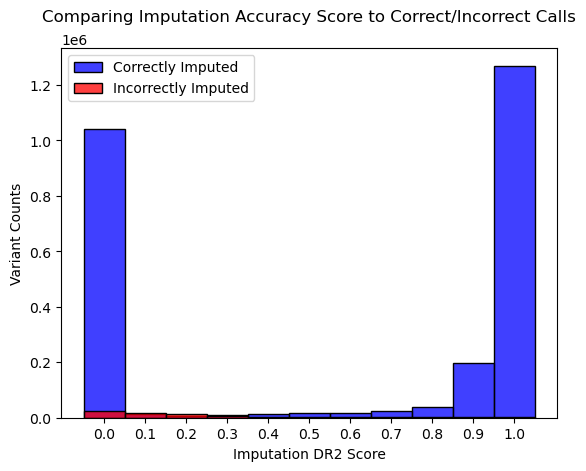

In [70]:
#Superimposed plots
sns.histplot(equiv_scores, bins=50, color='blue', label='Correctly Imputed')
sns.histplot(unequiv_scores, bins=50, color='red', label='Incorrectly Imputed')

plt.xlabel('Imputation DR2 Score')  
plt.ylabel('Variant Counts')  
plt.title('Comparing Imputation Accuracy Score to Correct/Incorrect Calls', y=1.05)

plt.legend()
plt.show()

In [ ]:
# DR2 =  subfield with the estimated squared correlation between the estimated allele dose and the true allele dose

In [58]:
c_unequiv = len(unequiv_scores)

In [59]:
c_equiv = len(equiv_scores)
total = c_equiv+c_unequiv

In [60]:
print(c_unequiv/total)

0.02811054760100741


In [61]:
num = 15000+12500+7500

In [62]:
improved = c_unequiv - num

In [63]:
print(improved/total)

0.015249680866778324


In [64]:
seen = set()
for item in equiv_scores:
    if item not in seen:
        seen.add(item)
        
counts = {item:0 for item in seen}
for item in equiv_scores:
    counts[item] +=1

In [65]:
counts

{'0.7': 23676,
 '0.4': 12822,
 '0.6': 16911,
 '0.9': 196992,
 '0.0': 1041239,
 '0.5': 15326,
 '1.0': 1269312,
 '0.1': 11931,
 '0.2': 6651,
 '0.3': 9830,
 '0.8': 40243}